In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/Spoiler Detection/LM-BFF"
%ls

/content/drive/MyDrive/Spoiler Detection/LM-BFF
 auto_label_mapping/               log.lock
 auto_template/                    README.md
 data/                             requirements.txt
 discord_log                       result/
 eda.ipynb                         run_experiment.sh
 ensemble_predict_results/         run.ipynb
'ensemble_predict_results'$'\r'/   run_multiple.sh
 ensemble.sh                       run.py
 env/                              spoilers_auto_label_mapping/
 evaluate.ipynb                    spoilers_auto_template/
 figs/                             src/
 label_search.sh                   template_search.sh
 LICENSE                           tools/
 log                               uncertain_log


In [11]:
!source env/bin/activate; python -m pip install --upgrade pip
# !source env/bin/activate; pip install torchmetrics
# !pip install torchmetrics

In [12]:
import numpy as np
import pandas as pd
from torchmetrics.functional import auroc, precision_recall_curve, fbeta_score
import torch.nn.functional as F
import torch

In [87]:
# Select best threshold based on validation set
valset = pd.read_csv('data/k-shot/spoilers/250-21/dev.csv', header=None).values
labels = torch.tensor(valset[:, 0].astype(int))

logits = np.load('result/no_demo-spoilers-prompt-250-21-roberta-large/spoilers--1--1-eval.npy')
logits = torch.tensor(logits)
pos_score = F.softmax(logits, dim=1)[:, 1]

print('AUROC: {}'.format(auroc(pos_score, labels, pos_label=1)))

precision, recall, thresholds = precision_recall_curve(pos_score, labels, pos_label=1, num_classes=1)

fscores = [fbeta_score(pos_score, labels, beta=1.2, threshold=threshold, num_classes=1) for threshold in thresholds]
idx = np.argmax(fscores)

SELECTED_THRESHOLD = thresholds[idx].item()

idx, fscores[idx].item(), SELECTED_THRESHOLD

AUROC: 0.8701279759407043


(202, 0.7964967489242554, 0.1156720519065857)

In [88]:
testset = pd.read_csv('data/k-shot/spoilers/250-21/test.csv', header=None).values
labels = torch.tensor(testset[:, 0].astype(int))

logits = np.load('result/no_demo-spoilers-prompt-250-21-roberta-large/spoilers--1--1-test.npy')
logits = torch.tensor(logits)
pos_score = F.softmax(logits, dim=1)[:, 1]

print('AUROC: {}'.format(auroc(pos_score, labels, pos_label=1)))

precision, recall, thresholds = precision_recall_curve(pos_score, labels, pos_label=1, num_classes=1)

fbeta_score(pos_score, labels, beta=1.2, threshold=SELECTED_THRESHOLD, num_classes=1).item()

AUROC: 0.872575581073761


0.7624264359474182

Recall: 0.8576158881187439, Precision: 0.6556962132453918, Threshold: 0.11552929133176804


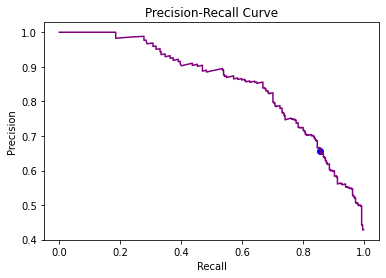

In [89]:
import matplotlib.pyplot as plt
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

idx = (thresholds < SELECTED_THRESHOLD).sum() - 1
ax.scatter(recall[idx], precision[idx], color='blue')
print('Recall: {}, Precision: {}, Threshold: {}'.format(
    recall[idx], precision[idx], thresholds[idx]
))

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [90]:
def get_predictions(probs, labels, threshold):
    pred = probs > threshold
    TP = torch.logical_and(pred == 1, labels == 1).sum()
    FP = torch.logical_and(pred == 1, labels == 0).sum()
    TN = torch.logical_and(pred == 0, labels == 0).sum()
    FN = torch.logical_and(pred == 0, labels == 1).sum()

    return TP, FP, TN, FN

In [93]:
def get_improvement(pos_score, labels, threshold):
    TP, FP, TN, FN = get_predictions(pos_score, labels, threshold)
    print(TP.item(), FP.item(), TN.item(), FN.item())
    print('Accuracy before: {}'.format((TP + TN) / (TP + TN + FP + FN)))
    print('Accuracy after: {}'.format(TN / (TN + FN)))
    print('Examples before: {}'.format(TP + FP + TN + FN))
    print('Examples left: {}'.format(TN + FN))

get_improvement(pos_score, labels, SELECTED_THRESHOLD)

259 135 286 43
Accuracy before: 0.7538036108016968
Accuracy after: 0.869300901889801
Examples before: 723
Examples left: 329


In [78]:
print(get_predictions(pos_score, labels, SELECTED_THRESHOLD))

pred = pos_score > SELECTED_THRESHOLD
TP = torch.logical_and(pred == 1, labels == 1)
FP = torch.logical_and(pred == 1, labels == 0)
TN = torch.logical_and(pred == 0, labels == 0)
FN = torch.logical_and(pred == 0, labels == 1)

(tensor(279), tensor(216), tensor(205), tensor(23))


In [79]:
metrics = [(TP, 'Irrelevants that will be thrown out:'), 
           (FP, 'Relevants that will be sacrificed:'),
           (TN, 'Relevants that will be kept:'),
           (FN, 'Missed irrelevants:')]
def display_metric(metric):
    print(metric[1] + ' {}'.format(metric[0].sum()))
    print()
    for idx in range(len(metric[0])):
        if metric[0][idx]:
            print('{}: \t {}'.format(idx, testset[idx][1]))

In [80]:
display_metric(metrics[0]) # TP

Irrelevants that will be thrown out: 279

0: 	 i'm sorry but trying to stop eren is probably the worst move they could pull it feels so dumb
2: 	 What is going on? Can someone explain to me with plain English? I can't understand anything anymore
5: 	 Any theories or ideas what happens next… all my expectations have been averted so I have no idea what’s gonna happen. I mean I guess based off the intro we still have the rumbling with eren in control at this point but I rlly don’t know
7: 	 Didn't even realise there was an after credits scene until I was super confused when my housemates were talking about it.
8: 	 This is the first time that my heart rate has gone up for a truly worthwhile cause.
10: 	 Anyone know why Hulu doesn’t have season 4’s episode 17-25 dubbed? I know they release on Sunday’s, but is mine just messed up or are there actually that any dubs missing?  One of the absolute best animes I’ve watched & am a little discouraged if I have to wait to watch those. I totally wi

In [81]:
display_metric(metrics[1]) # FP

Relevants that will be sacrificed: 216

3: 	 How does Floch not know Armin's switched sides though? I thought he figured out their plan in episode 8 when he was asking for Mikasa.
4: 	 Hold on I want to clarify something, does Eren want to protect all the Eldians or just the Eldians in Paradise?

Like is he okay killing Eldians in marley and in other countries
6: 	 It’s like they’re trying to make memes on purpose now with Yelena’s face like that…
9: 	 annie are you ok?
11: 	 Dam this show is good, great to see Annie back, properly my favourite character or close but annoying she was trapped for years. I do like the older uniforms and looks better then the new ones
12: 	 So wait can Eren alter time now?
29: 	 There are so many sides to this that I'm curious who is rooting for who at this point especially with the Zeke/Eren double betrayal confirmed.

I see a lot of people rooting for Eren and that seems crazy to me even knowing he's not on Zeke's side.

Who are you guys rooting for?
33

In [82]:
display_metric(metrics[2]) # TN

Relevants that will be kept: 205

1: 	 Holy hell. For sure best episode of the season and what a freaking cliffhanger ending!

For a second there I low-key thought Eren was dead! But I guess Zeke will somehow bring him back with the founding power?

I also don’t exactly understand why Zeke is the one with the power and got Ymir to listen to him, instead of it being Eren. Can someone tell me why?

Ignoring that, we also finally got confirmation that Eren wasn’t going along with the euthanasia plan, which we all guessed! But we don’t really know what Eren’s plan is. Although now, he will just need to stop Zeke.

I need next week! As I bet most of the characters will start to help Eren fight Zeke, even Eren’s enemies.
14: 	 Anyone else feel like the introduction of Annie to the characters was a little rushed? Armin has been worried about her all this time and Connie saw innocent people slaughtered by her and neither of them seem really shocked to see her. I like the comedic scene to break

In [83]:
display_metric(metrics[3]) # FN

Missed irrelevants: 23

13: 	 My only concern is that they didn't seem to give Falco any time at all to practice with the Jaw. He hasn't even used it once, right? Seems unwise to go into a fight against anti-titan gear with a 100% noob titan on your team
24: 	 Doubt this would happen but just imagine if somehow Levi gets the juice and eats Falco, acquiring Jaw. Jesus the power
42: 	 how does Floch go from being a coward in battle to one of a scheming leader? That's a 180 degree change!

Also, Eren's life mission went from killing all titans to killing every human on earth except those on the island...
102: 	 Ok one thing I just thought about is how are new titans being created right now?  Ymir had previously been making the titans as a slave but now she has a choice and would knowingly be helping Armin/Reiner/Falco/Annie stop Eren from completing his goal.  So she'd be actively fucking Eren and herself over presuming that she wants the same thing that Eren wants.
132: 	 One thing i rea